In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as Ker
import matplotlib.pyplot as plt

**I Path Simulation**

In [2]:
import tensorflow as tf

def simulate_paths_optimized(M, T, n, r, vol, S_initial, dt):
    
    nudt = (r - 0.5 * vol**2) * dt
    lnS_initial = tf.math.log(tf.cast(S_initial, tf.float32))
    

    Z = tf.random.normal([M, n], dtype=tf.float32)
    dW = tf.sqrt(dt) * Z  
    
    delta_lnS = nudt + vol * dW  
    
    cumulative_delta_lnS = tf.math.cumsum(delta_lnS, axis=1)
    lnS_paths = cumulative_delta_lnS + lnS_initial
    lnS_paths = tf.concat([tf.fill([M, 1], lnS_initial), lnS_paths], axis=1)
    
    S = tf.exp(lnS_paths)
    return S, dW

M = 100000
T = 1.0
n = 50
dt = T/n
r = 0.06
vol = 0.2
S_initial = 36.0
K=40.0

S, dW = simulate_paths_optimized(M, T, n, r, vol, S_initial, dt)
print("Simulated asset paths shape:", S.shape)


Simulated asset paths shape: (100000, 51)


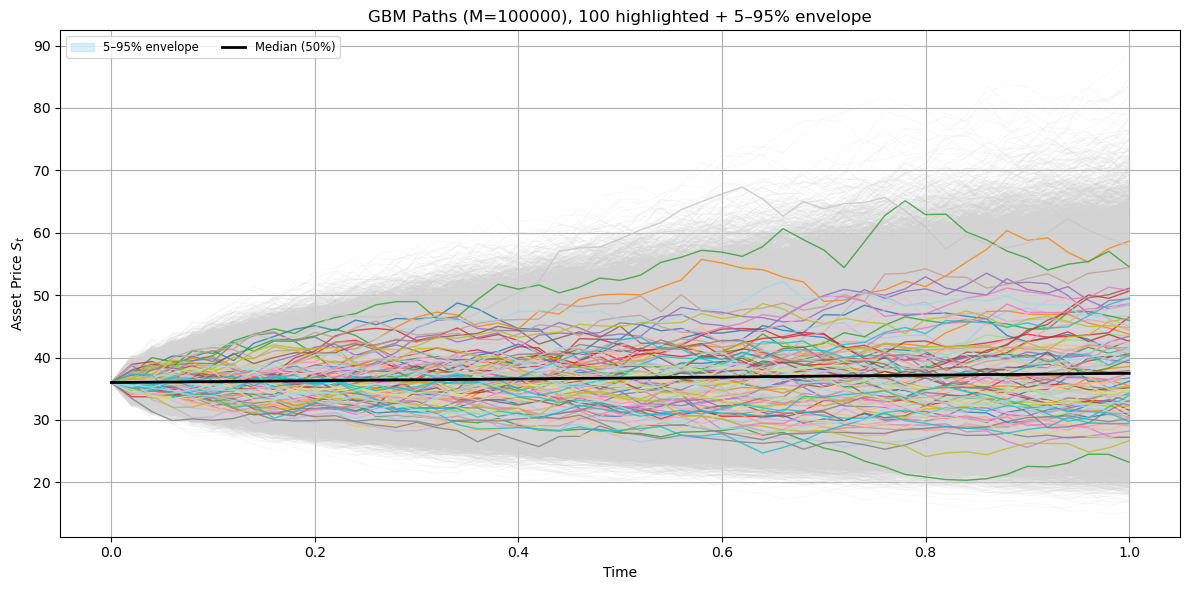

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Convert your TensorFlow tensor S to a NumPy array
S_np = S.numpy()          
M, n1 = S_np.shape
time_grid = np.linspace(0, T, n1)

# Envelope: 5% and 95% quantiles
q05 = np.quantile(S_np, 0.05, axis=0)
q95 = np.quantile(S_np, 0.95, axis=0)
med = np.quantile(S_np, 0.50, axis=0)

# Plot setup
plt.figure(figsize=(12,6))
plt.fill_between(time_grid, q05, q95, color='skyblue', alpha=0.3, label='5–95% envelope')
plt.plot(time_grid, S_np.T, color='lightgray', linewidth=0.5, alpha=0.2)

# Highlight 100 random paths
np.random.seed(0)
idx100 = np.random.choice(M, size=100, replace=False)
cmap = plt.get_cmap('tab20', 100)
for j, i in enumerate(idx100):
    plt.plot(time_grid, S_np[i, :], color=cmap(j), linewidth=1, alpha=0.8)

# Median path
plt.plot(time_grid, med, color='black', linewidth=2, label='Median (50%)')

# Labels and styling
plt.title(f'GBM Paths (M={M}), 100 highlighted + 5–95% envelope')
plt.xlabel('Time')
plt.ylabel('Asset Price $S_t$')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
def payoff(S, K):
    return tf.maximum(K - S, tf.constant(0.0, dtype=tf.float32))


In [5]:
X = tf.Variable(tf.zeros([M, n+1], dtype=tf.float32))
Y = tf.Variable(tf.zeros([M, n+1], dtype=tf.float32))
X_last_col = payoff(S[:, n], K)
X[:, n].assign(X_last_col)
Y[:, n].assign(X_last_col)
beta_dt = tf.exp(-r * dt)

**II Model Training**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# For Euler: num_outputs = 2 (φ, ψ)
# For Milstein: num_outputs = 3 (φ, ψ₁, ψ₂)
# For cubic variant: num_outputs = 4 (φ, ψ₁, ψ₂, ψ₃)
num_outputs = 4  

with tf.device('/GPU:0'):
    inputs = tf.keras.Input(shape=(1,))
    
    x = layers.Dense(100, activation="relu")(inputs)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)

    outputs = layers.Dense(num_outputs)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="multi_scheme_model")
    model.summary()

    # loss function.
    # For Euler (num_outputs=2), only the first term is used.
    # For Milstein (num_outputs=3), use: φ + ψ₁*dW + ψ₂*(dW^2 - dt)
    # For cubic (num_outputs=4), add: ψ₃*(dW^3 - 3*dt*dW)
    def custom_loss(y_true, y_pred):
        Y_true = y_true[:, 0]
        dW_true = y_true[:, 1]
        if num_outputs == 2:
            # Euler scheme
            prediction = y_pred[:, 0] + y_pred[:, 1] * dW_true
        elif num_outputs == 3:
            # Milstein scheme: second term = (dW^2 - dt)
            prediction = y_pred[:, 0] + y_pred[:, 1] * dW_true + y_pred[:, 2] * (tf.square(dW_true) - dt)
        elif num_outputs == 4:
            # Extended (cubic) scheme: third-order term = dW^3 - 3*dt*dW
            prediction = (y_pred[:, 0] +
                          y_pred[:, 1] * dW_true +
                          y_pred[:, 2] * (tf.square(dW_true) - dt) +
                          y_pred[:, 3] * (tf.pow(dW_true, 3) - 3 * dt * dW_true))
        else:
            raise ValueError("Unsupported number of outputs")
        return tf.reduce_mean(tf.square(Y_true - prediction))
    
    model.compile(optimizer='adam', loss=custom_loss)


Model: "multi_scheme_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,004 (160.17 KB)

 Trainable params: 41,004 (160.17 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    new_model.compile(optimizer=model.optimizer, loss=model.loss)
    new_model.set_weights(model.get_weights())
    return new_model
@tf.keras.utils.register_keras_serializable(package="Custom", name="custom_loss")

def custom_loss(y_true, y_pred):
    Y_true = y_true[:, 0]
    dW_true = y_true[:, 1]
    prediction = y_pred[:, 0] + y_pred[:, 1] * dW_true + y_pred[:, 2] * (tf.square(dW_true) - dt)
    return tf.reduce_mean(tf.square(Y_true - prediction))


In [8]:
scheme = 'milstein'  

if scheme == 'euler':
    num_outputs = 2
elif scheme == 'milstein':
    num_outputs = 3
elif scheme == 'cubic':
    num_outputs = 4
else:
    raise ValueError("Unsupported scheme")

L = []  

with tf.device('/GPU:0'):
    num_batch = 256
    epoch_size = 10
    

    for i in range(n-1, 0, -1):
        model_copy = clone_model(model)
        L.append(model_copy)

        concatenated_outputs = tf.concat([beta_dt * Y[:, i+1:i+2], dW[:, i:i+1]], axis=1)
        model.fit(S[:, i:i+1], concatenated_outputs, 
                  epochs=epoch_size, batch_size=num_batch, validation_split=0.1, verbose=0)
        outputs = model.predict(S[:, i:i+1], verbose=0)
        
        if scheme == 'euler':
            phi_S = outputs[:, 0]
            psi_S = outputs[:, 1]
            # Update value process using Euler: Y[t] = beta_dt * Y[t+1] - psi(S)*dW[t]
            X[:, i].assign(beta_dt * X[:, i+1] - psi_S * dW[:, i])
            Y[:, i].assign(beta_dt * Y[:, i+1] - psi_S * dW[:, i])
        elif scheme == 'milstein':
            phi_S = outputs[:, 0]
            psi_S = outputs[:, 1]
            psi_S_2 = outputs[:, 2]
            # Update using Milstein correction: include (dW^2 - dt)
            X[:, i].assign(beta_dt * X[:, i+1] - psi_S * dW[:, i] - psi_S_2 * (tf.square(dW[:, i]) - dt))
            Y[:, i].assign(beta_dt * Y[:, i+1] - psi_S * dW[:, i] - psi_S_2 * (tf.square(dW[:, i]) - dt))
        elif scheme == 'cubic':
            phi_S = outputs[:, 0]
            psi_S = outputs[:, 1]
            psi_S_2 = outputs[:, 2]
            psi_S_3 = outputs[:, 3]
            # Update with extended (cubic) term: add third-order term: dW^3 - 3 dt*dW
            X[:, i].assign(
                beta_dt * X[:, i+1] - psi_S * dW[:, i]
                - psi_S_2 * (tf.square(dW[:, i]) - dt)
                - psi_S_3 * (tf.pow(dW[:, i], 3) - 3 * dt * dW[:, i])
            )
            Y[:, i].assign(
                beta_dt * Y[:, i+1] - psi_S * dW[:, i]
                - psi_S_2 * (tf.square(dW[:, i]) - dt)
                - psi_S_3 * (tf.pow(dW[:, i], 3) - 3 * dt * dW[:, i])
            )
        else:
            raise ValueError("Unsupported scheme")
        
        #if immediate payoff exceeds φ(S), exercise.
        Z = payoff(S[:, i], K)

        Y[:, i].assign(tf.where(Z > phi_S, Z, Y[:, i]))
        X[:, i].assign(tf.where(Z > X[:, i], Z, X[:, i]))
        
        if i % 10 == 0:
            print("We are currently", 1 - i/float(n), "complete")
    
    # Finally, for i=0:
    i = 0
    concatenated_outputs = tf.concat([beta_dt * Y[:, i+1:i+2], dW[:, i:i+1]], axis=1)
    model.fit(S[:, i:i+1], concatenated_outputs, 
              epochs=epoch_size, batch_size=num_batch, validation_split=0.1, verbose=0)
    outputs = model.predict(S[:, i:i+1], verbose=0)
    
    if scheme == 'euler':
        phi_S = outputs[:, 0]
        psi_S = outputs[:, 1]
        X[:, 0].assign(beta_dt * X[:, 1] - psi_S * dW[:, 0])
        Y[:, 0].assign(beta_dt * Y[:, 1] - psi_S * dW[:, 0])
    elif scheme == 'milstein':
        phi_S = outputs[:, 0]
        psi_S = outputs[:, 1]
        psi_S_2 = outputs[:, 2]
        X[:, 0].assign(beta_dt * X[:, 1] - psi_S * dW[:, 0] - psi_S_2 * (tf.square(dW[:, 0]) - dt))
        Y[:, 0].assign(beta_dt * Y[:, 1] - psi_S * dW[:, 0] - psi_S_2 * (tf.square(dW[:, 0]) - dt))
    elif scheme == 'cubic':
        phi_S = outputs[:, 0]
        psi_S = outputs[:, 1]
        psi_S_2 = outputs[:, 2]
        psi_S_3 = outputs[:, 3]
        X[:, 0].assign(
            beta_dt * X[:, 1] - psi_S * dW[:, 0]
            - psi_S_2 * (tf.square(dW[:, 0]) - dt)
            - psi_S_3 * (tf.pow(dW[:, 0], 3) - 3 * dt * dW[:, 0])
        )
        Y[:, 0].assign(
            beta_dt * Y[:, 1] - psi_S * dW[:, 0]
            - psi_S_2 * (tf.square(dW[:, 0]) - dt)
            - psi_S_3 * (tf.pow(dW[:, 0], 3) - 3 * dt * dW[:, 0])
        )
       
    final_model_copy = clone_model(model)
    L.append(final_model_copy)


We are currently 0.19999999999999996 complete
We are currently 0.4 complete
We are currently 0.6 complete
We are currently 0.8 complete


In [ ]:
Z = payoff(S[:, i], K)
X[:, i].assign(tf.where(Z > X[:, i], Z, X[:, i]))

<tf.Variable 'UnreadVariable' shape=(100000, 51) dtype=float32, numpy=
array([[4.4757571e+00, 4.6865954e+00, 6.3227720e+00, ..., 7.0926437e+00,
        5.2938576e+00, 5.9988403e+00],
       [4.4955711e+00, 5.4771109e+00, 5.8608131e+00, ..., 8.3389206e+00,
        8.6459332e+00, 8.5933456e+00],
       [4.4928036e+00, 3.7264259e+00, 4.6411514e+00, ..., 2.3294694e+00,
        1.9132245e+00, 2.1419220e+00],
       ...,
       [4.4664431e+00, 3.4602320e+00, 2.3534803e+00, ..., 9.6455306e-02,
        6.0352068e-02, 0.0000000e+00],
       [4.4689960e+00, 4.4962006e+00, 4.9978185e+00, ..., 3.9044134e-03,
        0.0000000e+00, 0.0000000e+00],
       [4.5808988e+00, 3.5575876e+00, 3.4228745e+00, ..., 2.9525244e-01,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [10]:
u0 = X[:, 0].numpy().mean()
l0 = Y[:, 0].numpy().mean()
print(u0)
print(l0)

4.50648
4.4490447


**III Utilisation du modèle entariné**

In [11]:
beta_dt = tf.exp(-r * dt)
M2 = 300000 
S2, dW2 = simulate_paths_optimized(M2, T, n, r, vol, S_initial, dt)


In [12]:
X2 = tf.Variable(tf.zeros([M2, n+1], dtype=tf.float32))
Y2 = tf.Variable(tf.zeros([M2, n+1], dtype=tf.float32))
X2_last_col = payoff(S2[:, n], K)
X2[:, n].assign(X2_last_col)
Y2[:, n].assign(X2_last_col)

<tf.Variable 'UnreadVariable' shape=(300000, 51) dtype=float32, numpy=
array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         5.6622925],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         4.473839 ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
        10.822418 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         5.3404922]], dtype=float32)>

**Neural Networks**

              LB                            UB                    
scheme     cubic     euler  milstein     cubic     euler  milstein
strike                                                            
35      1.206824  1.089938  1.142885  1.231055  1.119477  1.167507
36      1.114775  1.641777  1.323981  1.119934  1.650387  1.335539
37      1.994473  1.877788  1.952496  2.020340  1.920804  1.978663
38      2.713801  2.732150  2.762368  2.787005  2.814168  2.823552
39      3.000000  3.000000  3.549293  3.293439  3.515518  3.647772
40      4.118543  4.000000  4.132810  4.217566  4.196620  4.216838
41      5.000000  5.106415  5.000000  5.251651  5.230861  5.093213
42      5.987358  6.000000  6.051135  6.107448  6.120997  6.140315
43      7.000000  6.972570  6.927602  7.104041  7.067450  7.106661
44      8.000000  8.000000  8.000000  8.100171  8.052210  8.072692
45      8.905551  8.878934  8.929554  9.069217  9.024478  9.025493


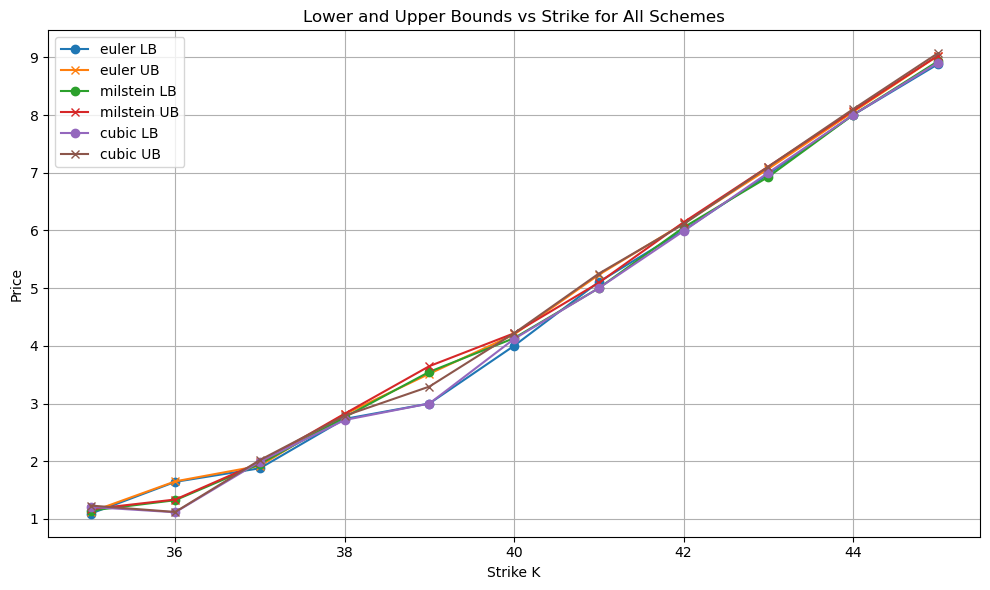

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --------- paramètres globaux ---------
M, T, n = 100_000, 1.0, 50
r, σ, S0 = 0.06, 0.2, 36.0
dt        = T / n
βinv      = tf.exp(-r * dt)             # β^{-1}_{Δt} = e^{-r Δt}
dt_sqrt   = np.sqrt(dt)

# strikes et schémas à tester
strikes = list(range(35, 46))           # 35 à 45 inclus
schemes = ['euler', 'milstein', 'cubic']

# split train/validation
val_frac = 0.1
idxs     = np.random.permutation(M)
n_val    = int(M * val_frac)
val_idx  = idxs[:n_val]
trn_idx  = idxs[n_val:]


def simulate_antithetic(M, n, S0, r, σ):
    half = M // 2
    Z    = tf.random.normal([half, n], dtype=tf.float32)
    Z    = tf.concat([Z, -Z], axis=0)
    dW   = dt_sqrt * Z
    drift = (r - 0.5*σ**2)*dt
    lnS = tf.concat([
        tf.fill([M,1], tf.math.log(S0)),
        tf.math.log(S0) + tf.cumsum(drift + σ*dW, axis=1)
    ], axis=1)
    return tf.exp(lnS), dW


def payoff_put(S, K):
    return tf.maximum(K - S, 0.0)


def make_phi_net():
    inp = layers.Input((1,))
    x = inp
    for _ in range(5):
        x = layers.Dense(100, activation='relu')(x)
    out = layers.Dense(1)(x)
    return tf.keras.Model(inp, out)


def make_psi_net(num_coef):
    inp = layers.Input((1,))
    x = inp
    for _ in range(5):
        x = layers.Dense(100, activation='relu')(x)
    out = layers.Dense(num_coef)(x)
    return tf.keras.Model(inp, out)


def bermudan_price(K, scheme='milstein'):
    num_coef = {'euler':1, 'milstein':2, 'cubic':3}[scheme]

    # 1) simulation pour backward
    S, dW = simulate_antithetic(M, n, S0, r, σ)
    logS = tf.math.log(S)

    # conteneurs Y (lower) et X (upper)
    Y = tf.Variable(tf.zeros([M, n+1], tf.float32))
    X = tf.Variable(tf.zeros([M, n+1], tf.float32))
    terminal = payoff_put(S[:, -1], K)
    Y[:, -1].assign(terminal)
    X[:, -1].assign(terminal)

    # placeholders warm-start
    phi_prev_wts, psi_prev_wts = None, None

    # backward loop
    for i in range(n-1, -1, -1):
        Si_all  = tf.expand_dims(logS[:, i], 1)
        dWi_all = dW[:, i]
        tgt_all = βinv * Y[:, i+1]

        # split train/valid
        Si_tr = tf.gather(Si_all, trn_idx)
        dw_tr = tf.gather(dWi_all, trn_idx)
        tg_tr = tf.gather(tgt_all, trn_idx)
        Si_va = tf.gather(Si_all, val_idx)
        dw_va = tf.gather(dWi_all, val_idx)
        tg_va = tf.gather(tgt_all, val_idx)

        # créer et warm-start réseaux
        phi_i = make_phi_net()
        psi_i = make_psi_net(num_coef)
        if phi_prev_wts is not None:
            phi_i.set_weights(phi_prev_wts)
            psi_i.set_weights(psi_prev_wts)

        opt = tf.keras.optimizers.Adam(1e-3, clipnorm=1.0)
        mse = tf.keras.losses.MeanSquaredError()

        # early-stopping manuel
        best_val, wait = np.inf, 0
        max_epochs, patience = 20, 3

        for epoch in range(max_epochs):
            # one SGD step
            with tf.GradientTape() as tape:
                φ_tr = tf.squeeze(phi_i(Si_tr, training=True), 1)
                Ψ_tr = psi_i(Si_tr, training=True)
                pred = φ_tr
                if scheme == 'euler':
                    pred += Ψ_tr[:,0] * dw_tr
                elif scheme == 'milstein':
                    pred += Ψ_tr[:,0] * dw_tr \
                          + Ψ_tr[:,1] * (dw_tr**2 - dt)
                else:  # cubic
                    pred += Ψ_tr[:,0] * dw_tr \
                          + Ψ_tr[:,1] * (dw_tr**2 - dt) \
                          + Ψ_tr[:,2] * (dw_tr**3 - 3*dt*dw_tr)
                loss_tr = mse(tg_tr, pred)
            grads = tape.gradient(
                loss_tr,
                phi_i.trainable_weights + psi_i.trainable_weights
            )
            opt.apply_gradients(zip(
                grads,
                phi_i.trainable_weights + psi_i.trainable_weights
            ))

            # validation
            φ_va = tf.squeeze(phi_i(Si_va, training=False), 1)
            Ψ_va = psi_i(Si_va, training=False)
            pred_va = φ_va
            if scheme == 'euler':
                pred_va += Ψ_va[:,0] * dw_va
            elif scheme == 'milstein':
                pred_va += Ψ_va[:,0] * dw_va \
                         + Ψ_va[:,1] * (dw_va**2 - dt)
            else:
                pred_va += Ψ_va[:,0] * dw_va \
                         + Ψ_va[:,1] * (dw_va**2 - dt) \
                         + Ψ_va[:,2] * (dw_va**3 - 3*dt*dw_va)
            loss_va = float(mse(tg_va, pred_va))

            if loss_va < best_val:
                best_val, wait = loss_va, 0
            else:
                wait += 1
                if wait >= patience:
                    break

        # stocker pour warm-start
        phi_prev_wts = phi_i.get_weights()
        psi_prev_wts = psi_i.get_weights()

        # mise à jour pathwise
        φ_all = tf.squeeze(phi_i(Si_all), 1)
        Ψ_all = psi_i(Si_all)
        if scheme == 'euler':
            tent = βinv * Y[:,i+1] - Ψ_all[:,0]*dWi_all
        elif scheme == 'milstein':
            tent = (βinv * Y[:,i+1]
                    - Ψ_all[:,0]*dWi_all
                    - Ψ_all[:,1]*(dWi_all**2 - dt))
        else:
            tent = (βinv * Y[:,i+1]
                    - Ψ_all[:,0]*dWi_all
                    - Ψ_all[:,1]*(dWi_all**2 - dt)
                    - Ψ_all[:,2]*(dWi_all**3 - 3*dt*dWi_all))

        Z_i = payoff_put(S[:, i], K)
        Y[:,i].assign(tf.where(Z_i > φ_all, Z_i, tent))
        X[:,i].assign(tf.where(Z_i > tent, Z_i, tent))

    # Lower and Upper bounds
    LB = float(tf.reduce_mean(Y[:,0]))
    UB = float(tf.reduce_mean(X[:,0]))
    return LB, UB


if __name__ == "__main__":
    # Collect results and print table
    records = []
    results = {sch: {'LB': [], 'UB': []} for sch in schemes}
    for sch in schemes:
        for K in strikes:
            lb, ub = bermudan_price(K, scheme=sch)
            records.append({'scheme': sch, 'strike': K, 'LB': lb, 'UB': ub})
            results[sch]['LB'].append(lb)
            results[sch]['UB'].append(ub)

    df = pd.DataFrame(records)
    print(df.pivot(index='strike', columns='scheme', values=['LB','UB']))

    # Single plot for all schemes
    plt.figure(figsize=(10,6))
    for sch in schemes:
        plt.plot(strikes, results[sch]['LB'], marker='o', label=f'{sch} LB')
        plt.plot(strikes, results[sch]['UB'], marker='x', label=f'{sch} UB')
    plt.title("Lower and Upper Bounds vs Strike for All Schemes")
    plt.xlabel("Strike K")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
# strikes  = list(range(35,46))
# schemes  = ['euler','milstein','cubic_withJ']
# results  = {
#     sch: {'LB': [...], 'UB': [...]}
#     for sch in schemes
# }

from tabulate import tabulate

rows = []
for idx, K in enumerate(strikes):
    # collect (scheme, lb_fresh, ub, gap) for this K
    group = []
    for sch in schemes:
        lb = results[sch]['LB'][idx]
        ub = results[sch]['UB'][idx]
        gap = ub - lb
        group.append((sch, lb, ub, gap))
    # sort by gap ascending
    group.sort(key=lambda x: x[3])
    # append to rows
    for sch, lb, ub, gap in group:
        rows.append([
            K,
            sch,
            f"{lb:.4f}",
            f"{ub:.4f}",
            f"{gap:.4f}",
        ])

print(tabulate(
    rows,
    headers=["Strike", "Scheme", "LB_fresh", "UB", "UB−LB_fresh"],
    tablefmt="github"
))


|   Strike | Scheme   |   LB_fresh |     UB |   UB−LB_fresh |
|----------|----------|------------|--------|---------------|
|       35 | cubic    |     1.2068 | 1.2311 |        0.0242 |
|       35 | milstein |     1.1429 | 1.1675 |        0.0246 |
|       35 | euler    |     1.0899 | 1.1195 |        0.0295 |
|       36 | cubic    |     1.1148 | 1.1199 |        0.0052 |
|       36 | euler    |     1.6418 | 1.6504 |        0.0086 |
|       36 | milstein |     1.324  | 1.3355 |        0.0116 |
|       37 | cubic    |     1.9945 | 2.0203 |        0.0259 |
|       37 | milstein |     1.9525 | 1.9787 |        0.0262 |
|       37 | euler    |     1.8778 | 1.9208 |        0.043  |
|       38 | milstein |     2.7624 | 2.8236 |        0.0612 |
|       38 | cubic    |     2.7138 | 2.787  |        0.0732 |
|       38 | euler    |     2.7321 | 2.8142 |        0.082  |
|       39 | milstein |     3.5493 | 3.6478 |        0.0985 |
|       39 | cubic    |     3      | 3.2934 |        0.2934 |
|       

**Hedging Strategy**

In [9]:
import tensorflow as tf
import numpy as np


def bermudan_price_ext(K, scheme='euler'):
    num_coef = {'euler':1, 'milstein':2, 'cubic':3}[scheme]

    S, dW = simulate_antithetic(M, n, S0, r, σ)


    phi = make_phi_net()
    psi = make_psi_net(num_coef)
    opt = tf.keras.optimizers.Adam(1e-3, clipnorm=1.0)
    mse = tf.keras.losses.MeanSquaredError()

    psi_wts = []


    Y = tf.Variable(tf.zeros([M, n+1], tf.float32))
    Y[:, -1].assign(payoff_put(S[:, -1], K))

    for i in range(n-1, -1, -1):
        Si     = tf.expand_dims(S[:, i], 1)   
        target = βdt * Y[:, i+1]               
        dWi    = dW[:, i]                      

        
        for _ in range(5):
            with tf.GradientTape() as tape:
                φp = tf.squeeze(phi(Si, training=True), 1)  
                Ψp = psi(Si, training=True)                   
                pred = φp + Ψp[:,0]*dWi
                if scheme in ('milstein','cubic'):
                    pred += Ψp[:,1]*(dWi**2 - dt)
                if scheme=='cubic':
                    pred += Ψp[:,2]*(dWi**3 - 3*dt*dWi)
                loss = mse(target, pred)
            grads = tape.gradient(
                loss,
                phi.trainable_weights + psi.trainable_weights
            )
            opt.apply_gradients(zip(
                grads,
                phi.trainable_weights + psi.trainable_weights
            ))

        
        psi_wts.append(psi.get_weights())

        φ_cont = tf.squeeze(phi(Si, training=False),1)
        upd    = βdt*Y[:,i+1] - psi(Si, training=False)[:,0]*dWi
        if scheme in ('milstein','cubic'):
            upd -= psi(Si, training=False)[:,1]*(dWi**2 - dt)
        if scheme=='cubic':
            upd -= psi(Si, training=False)[:,2]*(dWi**3 - 3*dt*dWi)
        Z = payoff_put(S[:, i], K)
        Y[:, i].assign(tf.where(Z>φ_cont, Z, upd))

    
    S2, dW2 = simulate_antithetic(M, n, S0, r, σ)

    
    return psi_wts, S2.numpy(), dW2.numpy()


def compute_hedges(psi_wts, S2, βdt, σ):
    M_test, n_plus1 = S2.shape
    n = n_plus1 - 1

    last_kernel = psi_wts[0][-2]
    num_coef = last_kernel.shape[1]

    psi = make_psi_net(num_coef)
    hedges = []
    for t in range(n):
        psi.set_weights(psi_wts[n-1-t])
        St = tf.expand_dims(S2[:, t], 1)
        Ht = psi(St, training=False).numpy()
        βt = float(βdt.numpy()**t)
        hedges.append(βt * Ht / σ)
    return np.stack(hedges, axis=1)  

hedge_results = {}
for sch in ['euler','milstein','cubic']:
    psi_wts, S2, dW2 = bermudan_price_ext(40, sch)
    hedges = compute_hedges(psi_wts, S2, βdt, σ)
    hedge_results[sch] = hedges
    print(f"{sch}: hedges shape = {hedges.shape}")


euler: hedges shape = (100000, 50, 1)
milstein: hedges shape = (100000, 50, 2)
cubic: hedges shape = (100000, 50, 3)


In [10]:
import numpy as np

for scheme, hedges in hedge_results.items():
    print(f"\n=== {scheme.upper()} HEDGE STRATEGY ===")

    print("First simulation path hedge over time:")
    print(hedges[0, :, :])  
    
    avg = np.mean(hedges, axis=0)  
    print("\nAverage hedge across all paths:")
    print(avg)
    
    if scheme == 'euler':
        print("\nDelta (J_t) first path:")
        print(hedges[0, :, 0])
        print("Delta (J_t) average:")
        print(avg[:, 0])



=== EULER HEDGE STRATEGY ===
First simulation path hedge over time:
[[-23.975613 ]
 [-24.934557 ]
 [-26.30946  ]
 [-25.932886 ]
 [-26.808342 ]
 [-25.110254 ]
 [-25.923555 ]
 [-24.524553 ]
 [-22.658089 ]
 [-22.400827 ]
 [-21.478876 ]
 [-22.935686 ]
 [-21.926128 ]
 [-21.600136 ]
 [-20.516304 ]
 [-20.989365 ]
 [-20.219816 ]
 [-19.27473  ]
 [-20.069887 ]
 [-18.533737 ]
 [-19.846142 ]
 [-20.595858 ]
 [-18.645306 ]
 [-17.75713  ]
 [-18.680723 ]
 [-17.574371 ]
 [-17.041262 ]
 [-17.083326 ]
 [-16.538364 ]
 [-17.8749   ]
 [-16.385612 ]
 [-16.506157 ]
 [-17.971212 ]
 [-17.355265 ]
 [-15.318164 ]
 [-16.2813   ]
 [-16.269703 ]
 [-15.652679 ]
 [-14.637825 ]
 [-14.1012535]
 [-13.819794 ]
 [-12.499406 ]
 [-13.377103 ]
 [-14.598481 ]
 [-13.072282 ]
 [ -9.87031  ]
 [-11.761858 ]
 [-16.76198  ]
 [-15.580098 ]
 [ -3.7634113]]

Average hedge across all paths:
[[-23.993586 ]
 [-24.910322 ]
 [-25.020245 ]
 [-24.90049  ]
 [-25.351286 ]
 [-24.410908 ]
 [-25.081488 ]
 [-24.078913 ]
 [-23.017876 ]
 [-23.647423

**Longstaff (Polynomial Regression)**

In [ ]:
import tensorflow as tf

@tf.function
def LS_lower_bound(S: tf.Tensor, K: float, r: float, dt: float) -> tf.Tensor:
    S = tf.cast(S, tf.float32)                 
    K = tf.cast(K, tf.float32)
    r = tf.cast(r, tf.float32)
    dt = tf.cast(dt, tf.float32)

    f        = tf.maximum(K - S, 0.0)          
    terminal = f[:, -1]                         

    def step(cash_next, elems):
        St, Zt = elems                         
        disc    = tf.exp(-r * dt)
        itm     = Zt > 0.0                    
        count   = tf.reduce_sum(tf.cast(itm, tf.int32))

        def do_regress():
            S_itm   = tf.boolean_mask(St, itm)            
            C_itm   = tf.boolean_mask(cash_next, itm)*disc
            B_itm   = tf.stack([tf.ones_like(S_itm),
                                 S_itm,
                                 S_itm**2], axis=1)    
            coeffs  = tf.linalg.lstsq(B_itm,
                                     tf.expand_dims(C_itm,1),
                                     fast=False)           
            B_all   = tf.stack([tf.ones_like(St),
                                 St,
                                 St**2], axis=1)          
            return tf.squeeze(B_all @ coeffs, axis=1)     

        def no_regress():
            return cash_next * disc
        cont = tf.cond(count >= 3, do_regress, no_regress)
        exer = Zt
        return tf.where(exer > cont, exer, cont)

    S_rev = tf.reverse(S[:, :-1], axis=[1])                
    Z_rev = tf.reverse(f[:, :-1], axis=[1])                
    elems = (tf.transpose(S_rev), tf.transpose(Z_rev))    

    cash_seq = tf.scan(step, elems, initializer=terminal)  
    V0       = cash_seq[-1] * tf.exp(-r * dt)             
    return tf.reduce_mean(V0)

Ks = tf.cast(tf.range(35, 46, dtype=tf.int32), tf.float32)   

# simulate 
M, T, n = 100_000, 1.0, 50
r, vol, S0 = 0.06, 0.2, 36.0
dt = T/n
def simulate_gbm(M,T,n,r,σ,S0):
    dt   = T/n
    nudt = (r - 0.5*σ**2)*dt
    Z    = tf.random.normal([M,n],dtype=tf.float32)
    dW   = tf.sqrt(dt)*Z
    dln  = nudt + σ*dW
    ln0  = tf.math.log(S0)
    lnS  = tf.concat([tf.fill([M,1],ln0),
                      ln0 + tf.cumsum(dln,1)],1)
    return tf.exp(lnS)

S_sim = simulate_gbm(M, T, n, r, vol, S0)  

LBs = tf.map_fn(
    lambda K: LS_lower_bound(S_sim, K, r, dt),
    Ks,
    dtype=tf.float32
)

for K_val, lb in zip(Ks.numpy(), LBs.numpy()):
    print(f"K = {K_val:.0f}  →  LS lower‐bound = {lb:.4f}")

K = 35  →  LS lower‐bound = 0.3965
K = 36  →  LS lower‐bound = 0.8887
K = 37  →  LS lower‐bound = 1.5534
K = 38  →  LS lower‐bound = 2.2613
K = 39  →  LS lower‐bound = 3.0755
K = 40  →  LS lower‐bound = 3.9952
K = 41  →  LS lower‐bound = 4.9940
K = 42  →  LS lower‐bound = 5.9928
K = 43  →  LS lower‐bound = 6.9916
K = 44  →  LS lower‐bound = 7.9904
K = 45  →  LS lower‐bound = 8.9892


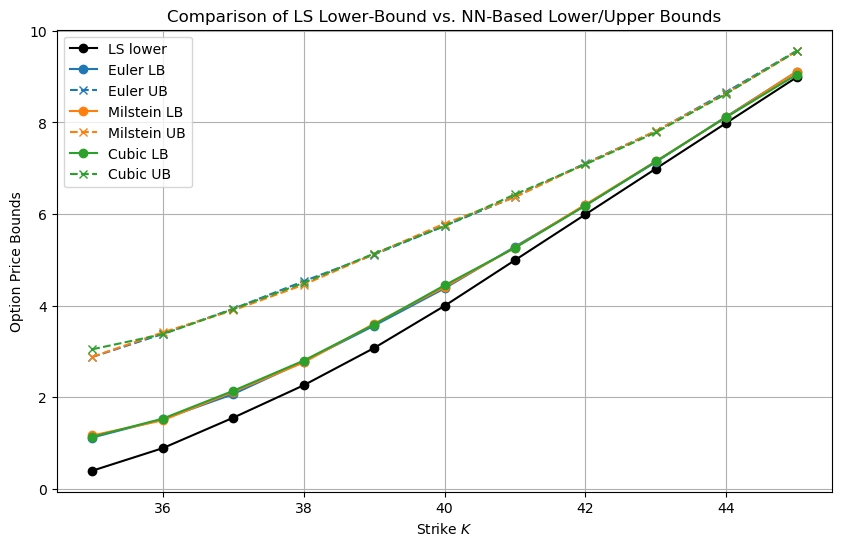

In [34]:
import matplotlib.pyplot as plt


strikes = list(range(35, 46))

ls_lbs = LBs.numpy()


euler_lbs    = [ results['euler'][K][0]    for K in strikes ]
euler_ubs    = [ results['euler'][K][1]    for K in strikes ]
milstein_lbs = [ results['milstein'][K][0] for K in strikes ]
milstein_ubs = [ results['milstein'][K][1] for K in strikes ]
cubic_lbs    = [ results['cubic'][K][0]    for K in strikes ]
cubic_ubs    = [ results['cubic'][K][1]    for K in strikes ]

plt.figure(figsize=(10,6))


plt.plot(strikes, ls_lbs,    '-k', label='LS lower',   marker='o')


plt.plot(strikes, euler_lbs,    '-C0', label='Euler LB',    marker='o')
plt.plot(strikes, euler_ubs,    '--C0', label='Euler UB',    marker='x')
plt.plot(strikes, milstein_lbs, '-C1', label='Milstein LB', marker='o')
plt.plot(strikes, milstein_ubs, '--C1', label='Milstein UB', marker='x')
plt.plot(strikes, cubic_lbs,    '-C2', label='Cubic LB',    marker='o')
plt.plot(strikes, cubic_ubs,    '--C2', label='Cubic UB',    marker='x')

plt.xlabel('Strike $K$')
plt.ylabel('Option Price Bounds')
plt.title('Comparison of LS Lower‐Bound vs. NN‐Based Lower/Upper Bounds')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Max-Call**

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 1) Simulation GBM 
def simulate_gbm(S0, r, delta, sigma, T, n_steps, n_paths, d):
    dt = T / n_steps
    S = np.zeros((n_steps+1, n_paths, d))
    S[0] = S0
    for t in range(n_steps):
        Z = np.random.normal(size=(n_paths, d))
        S[t+1] = S[t] * np.exp((r - delta - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    return S

# 2) Réseau continuation Φ : 
class PhiNet(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 50),
            nn.Softplus(),
            nn.Linear(50, 25),
            nn.Softplus(),
            nn.Linear(25, 1)
        )
    def forward(self, x):
        return self.net(x)

# 3) Réseau martingale Ψ :\
class PsiNet(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 50),
            nn.Softplus(),
            nn.Linear(50, 50),
            nn.Softplus(),
            nn.Linear(50, 2*d)
        )
    def forward(self, x):
        return self.net(x)

def price_bermudan_max_call_method1(
    S0, K, r, delta, sigma, T, n_steps, n_substeps,
    n_paths, d, n_epochs=20, batch_size=2048, lr=1e-3
):
    
    dt_coarse = T / n_steps
    beta = np.exp(-r * dt_coarse)
    
    S_paths = simulate_gbm(S0, r, delta, sigma,
                            T, n_steps*n_substeps, n_paths, d)
    
    payoff = np.maximum(S_paths.max(axis=2) - K, 0)
    Y = payoff.copy()
    X = payoff.copy()
    Phi_nets = [PhiNet(d) for _ in range(n_steps)]
    Psi_nets = [PsiNet(d) for _ in range(n_steps)]
    
    
    for i in reversed(range(n_steps)):
        t0 = i * n_substeps
        t1 = (i+1) * n_substeps
        
        
        S_t = torch.tensor(S_paths[t0], dtype=torch.float32)
        Y_next = torch.tensor(Y[t1], dtype=torch.float32).squeeze()
        
        
        S_next = S_paths[t1]
        log_ret = np.log(S_next / S_paths[t0])
        dW = (log_ret - (r - delta - 0.5*sigma**2)*dt_coarse) / sigma
        dW = torch.tensor(dW, dtype=torch.float32)

        
        targets = beta * Y_next
        
        ds = torch.utils.data.TensorDataset(S_t, dW, targets)
        loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
        
        Phi = Phi_nets[i]
        Psi = Psi_nets[i]
        optimizer = optim.Adam(list(Phi.parameters()) + list(Psi.parameters()), lr=lr)
        loss_fn = nn.MSELoss()
        
        Phi.train(); Psi.train()
        for epoch in range(n_epochs):
            for S_batch, dW_batch, tgt in loader:
                optimizer.zero_grad()
                cont = Phi(S_batch).squeeze()             
                
                
                out = Psi(S_batch)                        
                psi1, psi2 = out.chunk(2, dim=1)          
                mart1 = (psi1 * dW_batch).sum(dim=1)
                mart2 = (psi2 * (dW_batch**2 - dt_coarse)).sum(dim=1)
                mart  = mart1 + mart2                    
                
                loss = loss_fn(cont + mart, tgt)
                loss.backward()
                optimizer.step()
        
        Phi.eval(); Psi.eval()
        with torch.no_grad():
            cont_val = Phi(S_t).squeeze().numpy()       
            out_all = Psi(S_t).numpy()                  
            psi1_all, psi2_all = np.split(out_all, 2, axis=1)
            mart1_all = (psi1_all * dW.numpy()).sum(axis=1)
            mart2_all = (psi2_all * (dW.numpy()**2 - dt_coarse)).sum(axis=1)
            mart_all  = mart1_all + mart2_all
        
        Y[t0] = beta * Y[t1] - mart_all
        X[t0] = beta * X[t1] - mart_all
        
        exer = payoff[t0] > cont_val
        Y[t0][exer] = payoff[t0][exer]
        
        X[t0] = np.maximum(X[t0], payoff[t0])
    
    return Y[0].mean(), X[0].mean()


if __name__ == "__main__":
    d = 5
    S0 = np.array([100.0]*d)
    K = 100.0
    r = 0.05
    delta = 0.1
    sigma = 0.2
    T = 3.0
    n_steps = 9
    n_substeps = 32
    n_paths = 1_000_000   
    
    lb, ub = price_bermudan_max_call_method1(
        S0, K, r, delta, sigma, T,
        n_steps, n_substeps, n_paths, d,
        n_epochs=20, batch_size=4096, lr=1e-3
    )
    print(f"Lower Bound: {lb:.4f}, Upper Bound: {ub:.4f}")


Lower Bound: 25.7521, Upper Bound: 27.2261
